# Phased Arrays -- An Introduction
#### George Hutchinson (created for Going Down the EECS Stack, a DeCal by HKN)

## Shannon's Capacity Theorem: the quest for more bandwidth

We send and recieve information by modulating it onto the EM spectrum.
As a general rule, transmitting information faster requires using a wider "band" of spectrum to encode it.
A core result of classic information theory is **Shannon's Capacity Theorem**, which quantifies this observation by stating that the highest data rate that a digital communication can achieve relates to the bandwidth it uses, and to the **Signal-to-Noise ratio** of the power that it puts out into spectrum.

$$C = B \log_2(1+SNR)$$

where $C$ is the effective information moving through the channel (bits per second, not counting any bits used for error-correcting codes), $B$ is the channel bandwidth in Hertz, and $SNR = P/N$ is the ratio of total signal power to noise power reaching the reciever.
An important note is that Shannon's theorem only gives us a theoretical maximum, it doesn't say anything about how to actually achieve this limit.
A general rule is that more complicated modulation schemes (think NQAM as opposed to BPSK, for example) can move more information per bit, due to having more levels, but have higher SNR requirements to avoid level becoming ambiguous.



In theory, EM waves can wiggle as fast as we build the tech to make them.
However, there are practical limits --- for instance, water absorbes a lot of energy in the infrared bands (around 200THz), making free-space optical communication here on Earth (space is a different story) pretty much a non-starter.
There are also administrative limits on bandwidth.
In the US, the FCC (Federal Communications Commission) regulates the frequencies and power that electronics can use.

![US Wireless Spectrum Map (as of 2016)](./spectrum_chart.png)
[Image credit: United States Department of Commerce, Public domain, via Wikimedia Commons](https://commons.wikimedia.org/wiki/File:United_States_Frequency_Allocations_Chart_2016_-_The_Radio_Spectrum.pdf)

So, with the demand for wireless data growing rapidly, usable spectrum limited, and more signal power costly, what's a designer to do?

One idea towards an answer, which we'll explore below, is to use highly directional phased array antennas as filters in space.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.constants import c

## Cohenent and Incoherent EM waves

In free space, EM waves take the form of **plane waves**, with electric and magnetic components perpendicular to both each other and the direction that the wave is traveling.
Take a moment and think about what that enforces, spatially.
For a single propogation direction, there is a plane which it is perpendicular to.
Within that plane, you can choose any angle for the electric component of the wave, and then find that the direction of the magnetic component has only one valid answer.
This degree of freedom is called the **polarization** of a wave.

Below, we'll visualize snapshots of waves that might be traveling in the $\mathbf{x}$ direction, and what happens then we combine them.

In [2]:
def wave_x(polarization, phase, k, x):
    E = np.sin(k*x+phase) * np.exp(1j*polarization)
    B = np.sin(k*x+phase) * np.exp(1j*(polarization+np.pi/2))
    Ey = np.real(E)
    Ez = np.imag(E)
    By = np.real(B)
    Bz = np.imag(B)
    return Ey, Ez, By, Bz


In [3]:
polarization=0
phase=0
k=np.pi

xs = np.arange(0,4,0.001)
Ey, Ez, By, Bz = wave_x(polarization, phase, k, xs)

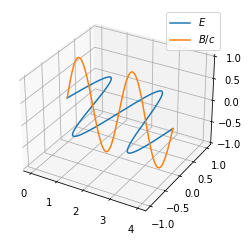

In [4]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(xs, Ey, Ez, label="$E$")
ax.plot(xs, By, Bz, label="$B/c$")
ax.legend()
## Note: natural units

In [5]:
pol0=0
pol1=np.pi/8
phase=0
k=np.pi
xs = np.arange(0,4,0.001)

wave0 = wave_x(pol0, phase, k, xs)
wave1 = wave_x(pol1, phase, k, xs)
wavesum = [comp0+comp1 for comp0,comp1 in zip(wave0,wave1)]

Text(0.5, 0.92, 'A nearly coherent sum of two waves')

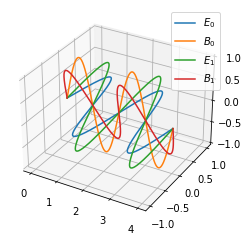

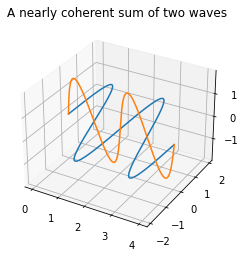

In [6]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(xs, wave0[0], wave0[1], label="$E_0$")
ax.plot(xs, wave0[2], wave0[3], label="$B_0$")
ax.plot(xs, wave1[0], wave1[1], label="$E_1$")
ax.plot(xs, wave1[2], wave1[3], label="$B_1$")
ax.legend()

ax = plt.figure().add_subplot(projection='3d')
ax.plot(xs, wavesum[0], wavesum[1], label="$E_{sum}$")
ax.plot(xs, wavesum[2], wavesum[3], label="$B_{sum}$")

plt.title("A nearly coherent sum of two waves")
## Note: natural units

In [7]:
pol=0
phase0=0
phase1=np.pi*7/8
k=np.pi
xs = np.arange(0,4,0.001)

wave0 = wave_x(pol, phase0, k, xs)
wave1 = wave_x(pol, phase1, k, xs)
wavesum = [comp0+comp1 for comp0,comp1 in zip(wave0,wave1)]

Text(0.5, 0.92, 'A nearly incoherent sum of two waves')

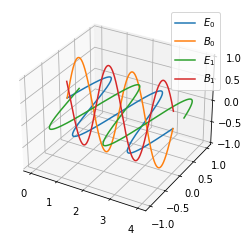

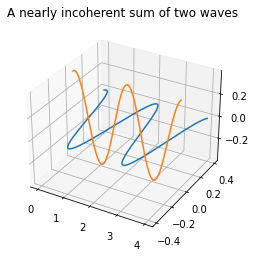

In [8]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(xs, wave0[0], wave0[1], label="$E_0$")
ax.plot(xs, wave0[2], wave0[3], label="$B_0$")
ax.plot(xs, wave1[0], wave1[1], label="$E_1$")
ax.plot(xs, wave1[2], wave1[3], label="$B_1$")
ax.legend()

ax = plt.figure().add_subplot(projection='3d')
ax.plot(xs, wavesum[0], wavesum[1], label="$E_{sum}$")
ax.plot(xs, wavesum[2], wavesum[3], label="$B_{sum}$")

plt.title("A nearly incoherent sum of two waves")
## Note: natural units

## Phased Arrays and Beamsteering

![phased array intro image](./phased_array_intro.png)
[Image credit: Analog Devices](https://www.analog.com/en/analog-dialogue/articles/phased-array-antenna-patterns-part1.html)

In order to exploit this idea of coherent and incoherent waves, consider how a wave changes as it travels from the location of one recieving antenna to another nearby one.
If the wave is coming from straight on, it will arrive at both at the same time (and therefore phase).
If, however, a wave arrives at an angle, it will have to travel further to arrive at the leftmost antenna vs the rightmost, picking up some phase as it travels.
A phased-array reciever shifts incomming signals to reverse this phase-shift, and then sums them.
Waves arriving from the desired direction will sum coherently, but others will sum incoherently.

It is less intuitive to visualize a transmitting phased array, but one can remember the antennas are **recipricoal** devices, where putting power into spectrum and recieving power from spectrum will satisfy the same relationships, with only causility reversed.

First, let's model a single, **isotropic** (sending power equally in all directions) antenna.
As an observer moves away from the antenna, she will observe a decay in the power from the antenna reaching her proportional to $r^{-2}$, which can be explained as the volume of the concentric spherical shells that this power is distributed across scaling like $r^{2}$.

In [9]:
def iso_free_path_loss(lam, r):
    return (lam/(4*np.pi*r))**2

def isotropic_characteristic(p, theta, phi):
    return 1

In [10]:
def heatmap(data, xs, ys, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Helper function for making a labeled heatmap from samples of a 2d function

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    xs
        An array of shape (N,) containing x values.
    ys
        An array of shape (M,) containing y values.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        A label for the color bar.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data,
                   extent=(np.min(xs), np.max(xs), np.min(ys), np.max(ys)),
                   **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
#     ax.set_xlim(np.min(xs),np.max(xs))
#     ax.set_ylim(np.min(ys),np.max(ys))

    return im, cbar


(<matplotlib.image.AxesImage at 0x7fabc6855430>,
 <matplotlib.colorbar.Colorbar at 0x7fabc686bd00>)

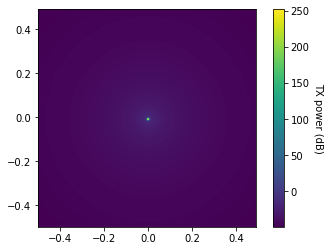

In [11]:
def single_antenna_power_2d(params,x,y):
    lam = params[0]
    r = np.sqrt(x**2+y**2)
    phi = np.arctan2(y,x)
    theta = np.pi/2
    pout = iso_free_path_loss(lam, r) * isotropic_characteristic(params, theta, phi)
    return 10*np.log10(pout)

xs = np.arange(-0.5,0.5,0.01)
ys = np.arange(-0.5,0.5,0.01)
xxs, yys = np.meshgrid(xs, ys)
data = single_antenna_power_2d([0.03],xxs,yys)

heatmap(data, xs, ys, cbarlabel="TX power (dB)")

In order to model phased arrays, we'll model the power than a single antenna is putting out with a single complex number.
Here, the magnitude is the absolute power that a single antenna in the array would be putting out from its position $(x_i,y_i)$, and the phase is equal to how far "into the next wavelength" the wave has traveled.
$$P_k(x,y) = P_{single}(x-x_k,y-y_k) \cdot \exp({2 \pi i \frac{r_k}{\lambda} + i \Delta\phi_k})$$

In [12]:
def single_antenna_power_2d_offset(p,x,y,xi,yi):
    return single_antenna_power_2d(p,x-xi,y-yi)
    
def array_power_2d(params, x, y):
    lam, N, d, phase_offsets = params
    xis = np.arange(N)*d
    yis = np.zeros(N)
    ris = np.sqrt((x-xis)**2+(y)**2)
    phases = np.exp(2j*np.pi * ris/lam + 1j*phase_offsets)
    pows = single_antenna_power_2d_offset([lam],x,y,xis,yis) * phases
    pout = np.sum(pows,axis=-1) / N
    return 20*np.log10(np.abs(pout))

In [13]:
lam = 0.003
N = 100
d = lam/4
phase_offsets = np.zeros(N)
params = lam, N, d, phase_offsets

xs = np.arange(-0.5,0.5,0.01)
ys = np.arange(-0.5,0.5,0.01)

data = np.array([array_power_2d(params, x, y) for y in ys for x in xs])
data = data.reshape(len(xs),len(ys))

(<matplotlib.image.AxesImage at 0x7fabc67c90d0>,
 <matplotlib.colorbar.Colorbar at 0x7fabc67747c0>)

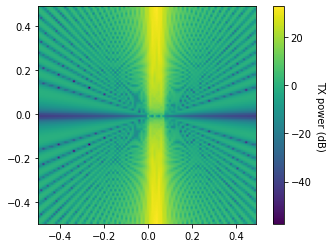

In [14]:
heatmap(data, xs, ys, cbarlabel="TX power (dB)")

# plt.imshow(data)

In [15]:
lam = 0.003
N = 100
d = lam/4
phase_offsets = 0.5*np.arange(N)
params = lam, N, d, phase_offsets

xs = np.arange(-0.5,0.5,0.01)
ys = np.arange(-0.5,0.5,0.01)

data = np.array([array_power_2d(params, x, y) for y in ys for x in xs])
data = data.reshape(len(xs),len(ys))

(<matplotlib.image.AxesImage at 0x7fabc675d8e0>,
 <matplotlib.colorbar.Colorbar at 0x7fabc4f16160>)

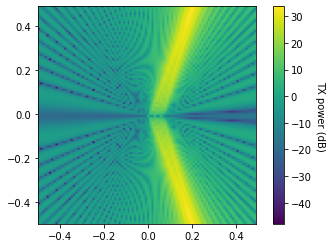

In [16]:
heatmap(data, xs, ys, cbarlabel="TX power (dB)")

When we set the phase offset like above ($\Delta\phi_k = k \cdot \Delta\phi_{ref}$), note that we can factor $k$ out of the overall exponent.
That means that the sum to compute total power from the array is a geometric series, and there's a nice identity for large arrays.
We can write the **array factor**, a function of angle sufficiently far away from the array, for easier computation.
$$AF(\phi) = \frac{ \sin(\frac{Nd\pi}{\lambda} (\sin(phi) - \sin(\Delta\phi) ) }{ N \sin( \frac{d \pi}{\lambda} (\sin(phi) - \sin(\Delta\phi)}$$
As an aside, this class of function is called a **periodic sinc**.

In [17]:
def array_factor(p, phi):
    lam, N, d, delta_phi = p
    t = d*np.pi/lam*(np.sin(phi) - np.sin(delta_phi))
    return np.sin(N*t)/N/np.sin(t)

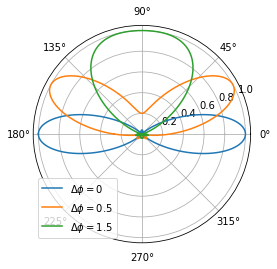

In [18]:
phis = np.arange(-np.pi,np.pi,0.001)

lam = 0.003
N = 5
d = lam/4
delta_phis = [0,0.5,1.5]

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

for delta_phi in delta_phis:
    af = array_factor((lam,N,d,delta_phi), phis)
    ax.plot(phis,af**2, label=f"$\Delta\phi={delta_phi}$")
ax.legend()

Look at how we can "steer" the beam by properly choosing $\Delta\phi$, but there's a second lobe corresponding to the backwards beam in the 2d simulations above.
Also, note that there are points where this array factor is identically zero.
This is a vaulable tool when using phased arrays for MIMO (multiple-in, multiple-out) communications.
Signals can share bandwidth, but not meaningfully interfere with each other because they are filtered out relative to each other in space.

![MIMO channel model](https://upload.wikimedia.org/wikipedia/commons/0/0f/Kanalmatrix_MIMO.png)

[Benbaum, Public domain, via Wikimedia Commons](https://commons.wikimedia.org/wiki/File:Kanalmatrix_MIMO.png)

Schematic of a MIMO communication setup with three transmitters and three recievers. Some arrows physically cross each other (no amount of spatial filtering would allow both to communicate at once; they would need to separate in time or frequency), but others do not, so if the transmitters had properly designed phased arrays, each individual signal could use more bandwidth (faster data rates, better quality calls/movie streaming).

To visualize a transmitter for a MIMO network, let's put together what we've made so far:

In [19]:
def MIMO_array_power_2d(params, x, y):
    lam, N, d, delta_phis = params
    r = np.sqrt(x**2+y**2)
    phi = np.arctan2(y,x)
    theta = np.pi/2
    array_factors = np.array([array_factor([lam, N, d, delta_phi], phi) for delta_phi in delta_phis])
    pout = iso_free_path_loss([lam],r) * isotropic_characteristic(params,phi,theta) * np.sum(array_factors**2)
    return 10*np.log10(pout)

In [20]:
lam = 0.003
N=64
d=lam/4
delta_phis=[-0.5,1.2]

arams = lam, N, d, delta_phis

xs = np.arange(-0.5,0.5,0.01)
ys = np.arange(-0.5,0.5,0.01)
xxs, yys = np.meshgrid(xs, ys)

data = np.array([MIMO_array_power_2d(params, x, y) for y in ys for x in xs])
data = data.reshape(len(xs),len(ys))
# Since this is a far-field approximation, remove points too close to handle
data[np.logical_and(abs(xxs) < N*d, abs(yys)<N*d)] = None

(<matplotlib.image.AxesImage at 0x7fabc684e130>,
 <matplotlib.colorbar.Colorbar at 0x7fabc69368b0>)

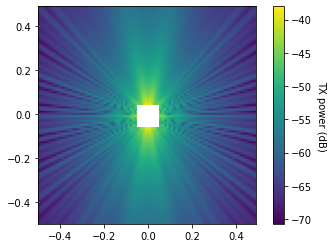

In [21]:
heatmap(data, xs, ys, cbarlabel="TX power (dB)")

## But how do we make one?

There are a few architectural options when designing with phased arrays, all permutations of where you fit the phase-shifters and power combiners/splitters in the signal chain.
One option is pictured here:
![Block diagram of one a phased array with RF shifting](./phased_array_arch.png)
[Image credit: Park, S.; Lee, J.-Y.; Lee, J.-Y.; Yang, J.-R.; Beak, D. 25–34 GHz Single-Pole, Double-Throw CMOS Switches for a Ka-Band Phased-Array Transceiver. Appl. Sci. 2018, 8, 196.](https://www.mdpi.com/2076-3417/8/2/196/htm)

Note the use of switches to select whether an antenna is in transmitting or recieving mode.
Designs that do that are gradually being phased out in favor of designs that use a **circulator**, a single non-recipricoal device that routes both  the transmit and recieve paths at the same time.
More to the point, this design chooses to place the phase-shifters post-modulation, where signals are in the RF band.
These devices are harder to design than phase-shifters for slower signals, but allow more fine-grained control.